# Image classifier for the SVHN dataset

## 1. Import Libraries

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import warnings
warnings.filterwarnings('ignore')

We will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz).

In [2]:
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 2. Inspect and preprocess the dataset

In [3]:
train_data, train_labels = train['X'], train['y']
test_data, test_labels = test['X'], test['y']

In [4]:
train_data = train_data/255
test_data = test_data/255

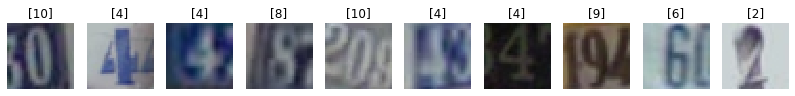

In [5]:
n = np.random.randint(0, train_labels.shape[0], 10)

plt.figure(figsize=(14,14))
for i in range(10):
    plt.subplot(1, 10, i+1)
    idx = n[i]
    plt.imshow(train_data[...,idx])
    plt.title(train_labels[idx])
    plt.axis('off')

In [6]:
train_data = np.moveaxis(train_data, -1, 0)
test_data = np.moveaxis(test_data, -1, 0)

Images are of 3 channels i.e RGB. But these channels does not manipulate the data.So it is better to convert the image to 1 channel or use greyscaled. Hence averaging over the third axis (depth or number of channels).

In [7]:
train_data = np.average(train_data, axis = 3)
test_data = np.average(test_data, axis = 3)

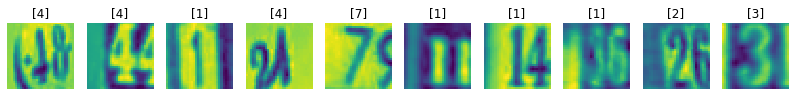

In [8]:
n = np.random.randint(0, train_labels.shape[0], 10)

plt.figure(figsize=(14,14))
for i in range(10):
    plt.subplot(1, 10, i+1)
    idx = n[i]
    plt.imshow(train_data[idx])
    plt.title(train_labels[idx])
    plt.axis('off')

In [9]:
train_data = np.expand_dims(train_data, axis = -1)
test_data = np.expand_dims(test_data, axis = -1)

In [10]:
enc = OneHotEncoder()
enc.fit(train_labels)
train_labels = enc.transform(train_labels).toarray()
test_labels = enc.transform(test_labels).toarray()

## 3. MLP neural network classifier


In [11]:
model = Sequential([Flatten(input_shape = train_data[0].shape),
                   Dense(256, activation = 'relu', kernel_initializer = 'he_uniform'),
                   Dense(128, activation = 'relu'),        
                   Dense(64, activation = 'relu'),
                   Dense(32, activation = 'relu'),
                   Dense(10, activation= 'softmax')])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 305,962
Trainable params: 305,962
Non-trainable params: 0
__________________________________________________

Making use of some callbacks to avoid overfitting and saving the weights including the best weights.

In [13]:
checkpoint_path = 'checkpoint/checkpoint_{epoch:02d}'
checkpoint_best_path = 'checkpoint_best/checkpoint'

checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only= True)
checkpoint_best = ModelCheckpoint(checkpoint_best_path, save_best_only= True, 
                                  save_weights_only= True, monitor= 'val_loss', mode = 'max')
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [14]:
history = model.fit(x = train_data, y= train_labels, validation_split = 0.1,
                    epochs = 30, callbacks= [checkpoint, checkpoint_best, early_stop])

Epoch 1/30
2061/2061 [==============================] - 15s 7ms/step - loss: 2.0484 - acc: 0.2655 - val_loss: 1.6817 - val_acc: 0.4222
Epoch 2/30
2061/2061 [==============================] - 13s 6ms/step - loss: 1.5339 - acc: 0.4680 - val_loss: 1.4386 - val_acc: 0.5072
Epoch 3/30
2061/2061 [==============================] - 12s 6ms/step - loss: 1.3288 - acc: 0.5597 - val_loss: 1.2662 - val_acc: 0.5803
Epoch 4/30
2061/2061 [==============================] - 12s 6ms/step - loss: 1.1779 - acc: 0.6232 - val_loss: 1.1188 - val_acc: 0.6440
Epoch 5/30
2061/2061 [==============================] - 12s 6ms/step - loss: 1.0877 - acc: 0.6559 - val_loss: 1.0689 - val_acc: 0.6552
Epoch 6/30
2061/2061 [==============================] - 13s 6ms/step - loss: 1.0227 - acc: 0.6794 - val_loss: 0.9907 - val_acc: 0.6880
Epoch 7/30
2061/2061 [==============================] - 12s 6ms/step - loss: 0.9834 - acc: 0.6911 - val_loss: 0.9649 - val_acc: 0.6888
Epoch 8/30
2061/2061 [==============================] -

In [15]:
df = pd.DataFrame(history.history)

In [16]:
def acc_loss_plot(data, accuracy = True):
    plt.figure(figsize = (5,5))
    plt.plot(data['loss'], c = 'blue', label = 'loss')
    plt.plot(data['val_loss'], c = 'orange', label = 'validation_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Validation Loss')

    if accuracy == True:
        plt.figure(figsize=(5,5))
        plt.plot(data['acc'], c ='blue', label = 'accuracy')
        plt.plot(data['val_acc'], c = 'orange', label = 'validation_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy vs Validation Accuracy')

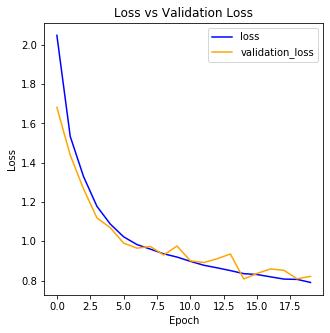

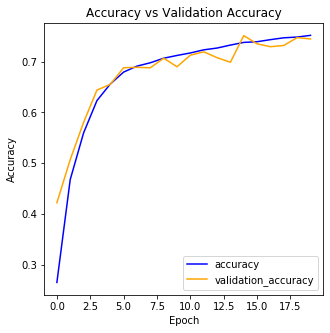

In [17]:
acc_loss_plot(df, True)

In [18]:
model.evaluate(test_data, test_labels)

814/814 [==============================] - 3s 3ms/step - loss: 0.9352 - acc: 0.7156


[0.935174286365509, 0.7155808210372925]

## 3. CNN neural network classifier
CNN layers can be useful in computer vision as it can better extract change in pixel over the image than the MLP neural network.

In [19]:
model_cnn = Sequential([Conv2D(16,3,padding= 'SAME', activation = 'relu', 
                               kernel_initializer='he_uniform', input_shape = (32,32,1)),
                        MaxPool2D(4, strides = 4),
                        Conv2D(32, 5, activation = 'relu'),
                        Flatten(),
                        Dense(32, activation= 'relu'),
                        Dense(16, activation='relu'),
                        Dense(10, activation='softmax')])

model_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [20]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 32)          12832     
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

In [21]:
checkpoint_cnn_path = 'checkpoint_cnn/checkpoint_{epoch:02d}'
checkpoint_best_cnn_path = 'checkpoint_cnn_best/checkpoint'

checkpoint_cnn = ModelCheckpoint(checkpoint_cnn_path, save_weights_only= True)
checkpoint_best_cnn = ModelCheckpoint(checkpoint_best_cnn_path, save_best_only= True, 
                                  save_weights_only= True, monitor= 'val_loss', mode = 'max')

In [22]:
history_cnn = model_cnn.fit(x = train_data, y= train_labels, validation_split = 0.1, epochs = 30, callbacks= [checkpoint_cnn, checkpoint_best_cnn ,early_stop])

Epoch 1/30
2061/2061 [==============================] - 28s 14ms/step - loss: 1.3966 - acc: 0.5319 - val_loss: 0.8427 - val_acc: 0.7366
Epoch 2/30
2061/2061 [==============================] - 27s 13ms/step - loss: 0.7271 - acc: 0.7820 - val_loss: 0.6551 - val_acc: 0.8025
Epoch 3/30
2061/2061 [==============================] - 28s 13ms/step - loss: 0.6227 - acc: 0.8117 - val_loss: 0.6205 - val_acc: 0.8123
Epoch 4/30
2061/2061 [==============================] - 28s 13ms/step - loss: 0.5713 - acc: 0.8273 - val_loss: 0.5545 - val_acc: 0.8332
Epoch 5/30
2061/2061 [==============================] - 28s 13ms/step - loss: 0.5388 - acc: 0.8375 - val_loss: 0.5578 - val_acc: 0.8306
Epoch 6/30
2061/2061 [==============================] - 28s 13ms/step - loss: 0.5125 - acc: 0.8446 - val_loss: 0.5517 - val_acc: 0.8347
Epoch 7/30
2061/2061 [==============================] - 28s 13ms/step - loss: 0.4935 - acc: 0.8501 - val_loss: 0.5527 - val_acc: 0.8290
Epoch 8/30
2061/2061 [==========================

In [23]:
df_cnn = pd.DataFrame(history_cnn.history)

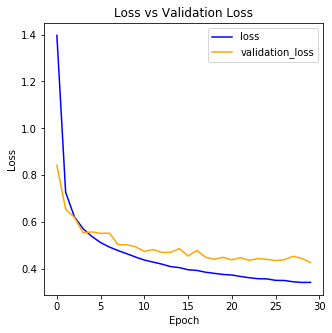

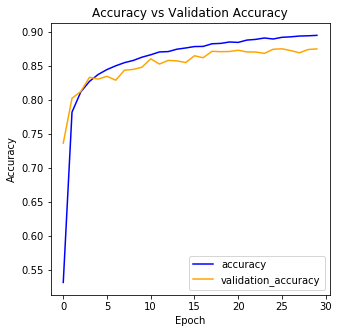

In [24]:
acc_loss_plot(df_cnn, True)

In [25]:
model_cnn.evaluate(test_data, test_labels)

814/814 [==============================] - 5s 7ms/step - loss: 0.4814 - acc: 0.8608


[0.4814247786998749, 0.8608251214027405]

## 4. Model predictions

Loading the weights with lowest val_loss i.e. checkpoint with best weights

In [26]:
weights = model.load_weights(checkpoint_best_path)
weights_cnn = model_cnn.load_weights(checkpoint_best_cnn_path)

In [27]:
test_labels_inv = enc.inverse_transform(test_labels)

Plots to show prediction given by both the models.

We can observe that CNN model is getting better prediction as show by these randomly picked set from testing data.
And also CNN model is much more confident in predicting the digits as the frequencies of other digits are much less than that of MLP model.

In [118]:
n = np.random.randint(0, test_labels.shape[0], 5)

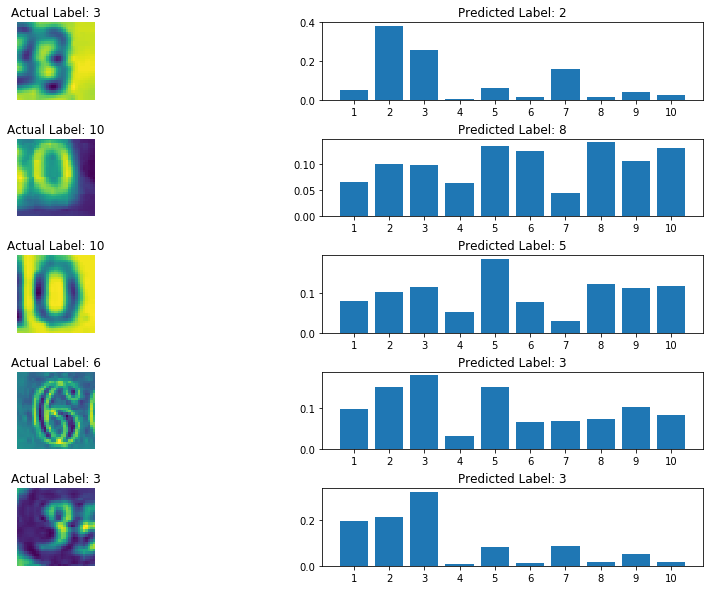

In [119]:
fig, ax = plt.subplots(5, 2, figsize = (15,10))

fig.subplots_adjust(hspace=0.5)

for i in range(len(n)):
    idx = n[i]
    p = model.predict(np.expand_dims(test_data[idx], axis = 0))
    ax[i,0].imshow(np.squeeze(test_data[idx], axis = -1))
    ax[i,0].set_axis_off()    
    ax[i,0].set_title(f'Actual Label: {int(test_labels_inv[idx])}')
    ax[i,1].bar([1,2,3,4,5,6,7,8,9,10], p.reshape(10))
    ax[i,1].set_xticks([1,2,3,4,5,6,7,8,9,10])
    ax[i,1].set_title(f'Predicted Label: {int(np.argmax(p)+ 1)}')

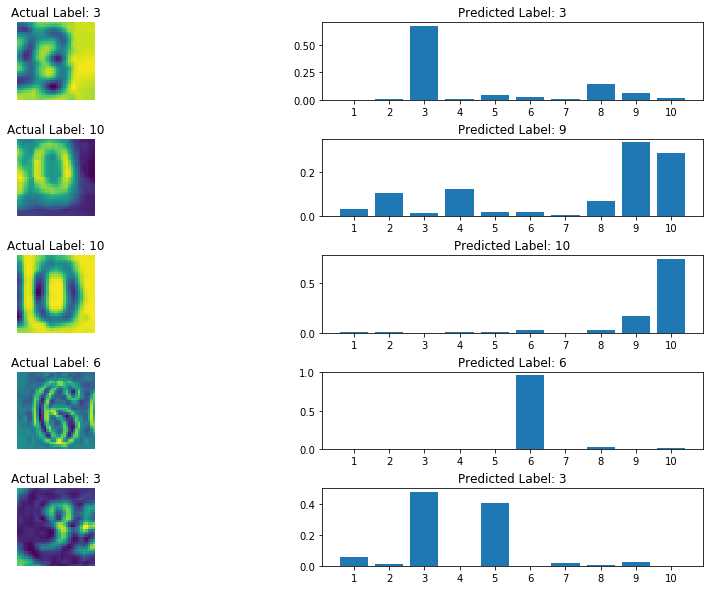

In [120]:
fig, ax = plt.subplots(5, 2, figsize = (15,10))

fig.subplots_adjust(hspace=0.5)

for i in range(len(n)):
    idx = n[i]
    p = model_cnn.predict(np.expand_dims(test_data[idx], axis = 0))
    ax[i,0].imshow(np.squeeze(test_data[idx], axis = -1))
    ax[i,0].set_axis_off()    
    ax[i,0].set_title(f'Actual Label: {int(test_labels_inv[idx])}')
    ax[i,1].bar([1,2,3,4,5,6,7,8,9,10], p.reshape(10))
    ax[i,1].set_xticks([1,2,3,4,5,6,7,8,9,10])
    ax[i,1].set_title(f'Predicted Label: {int(np.argmax(p)+ 1)}')